# Model validation

Historical NEMDE case files contain the inputs passed to the NEMDE, along with the outputs (dispatch targets and prices) returned by the program. Backtesting involves passing these same data to the Dispatch API's model and then comparing the outputs to those returned by the NEMDE. The degree to which the Dispatch API's solutions correspond to NEMDE outputs gives an indication as to the model's accuracy - the smaller the difference, the more accurate the approximation.

## Sample

Backtests are performed for all dispatch intervals between 2020-11-01 4:05:00 and 2020-12-01 4:00:00 (8640 dispatch intervals in total). 

## Metrics

Unless otherwise specified, summary statistics are computed for the difference between the Dispatch API's solution and NEMDE outputs, with the solution difference given by the following formula

```
Solution difference = Model solution - NEMDE solution.
```


Tables presenting summary statistics consist of columns corresponding to the key for which the solution difference has been computed, while rows display different metrics, the definitions of which are given in the following table:

| Name | Description |
| :--- | :---------- |
| count | Sample size |
| mean | Mean value |
| std | Standard deviation |
| min | Minimum value in sample |
| X % | X percentile |
| max | Maxiumum value in sample |



The raw data used to generate the following summary statistics can be downloaded [here](https://storage.googleapis.com/dispatch-api-backtest-results/f4ad6579b0fb42a0b344b1da2088b3d0.zip).

In [1]:
import os

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

import IPython.display as display


def load_backtest_results(run_id, filename):
    """Load backtest results"""

    file_path = os.path.join(os.path.curdir, 'results', run_id, filename)
    
    return pd.read_csv(file_path)


def get_summary_statistics(run_id, filename, element_id=None):
    """Compute summary statistics"""
    
    # Load results and compute difference between Dispatch API and NEMDE solution
    df = load_backtest_results(run_id=run_id, filename=filename)
    df['difference'] = df['model'] - df['actual']

    # Index to use when pivoting DataFrame
    if element_id is None:
        index = ['case_id', 'intervention']
    else:
        index = ['case_id', element_id, 'intervention']
    
    # Percentiles to include within summary statistics table
    percentiles =  [0.001, 0.01] + [0.1, 0.25, 0.5, 0.75, 0.9] + [0.99, 0.999]

    
    return (df.pivot(index=index, columns='key', values='difference')
            .describe(percentiles=percentiles))


def display_summary_statistics_markdown(run_id, filename, element_id=None):
    """Display summary statistics in a Markdown table"""
    
    summary = get_summary_statistics(run_id=run_id, filename=filename, 
                                     element_id=element_id)
    markdown = summary.to_markdown()
    
    return display.Markdown(markdown)


# Backtest run ID
run_id = 'f4ad6579b0fb42a0b344b1da2088b3d0'

### Period solution
Summary statistics for aggregate constraint violations and objective function values are shown in the following table.

In [2]:
display_summary_statistics_markdown(run_id=run_id, filename='periods.csv')

|       |   @TotalFastStartViolation |   @TotalGenericViolation |   @TotalInterconnectorViolation |   @TotalMNSPCapacityViolation |   @TotalMNSPOfferViolation |   @TotalMNSPRampRateViolation |   @TotalObjective |   @TotalRampRateViolation |   @TotalUIGFViolation |   @TotalUnitMWCapacityViolation |
|:------|---------------------------:|-------------------------:|--------------------------------:|------------------------------:|---------------------------:|------------------------------:|------------------:|--------------------------:|----------------------:|--------------------------------:|
| count |             8640           |           8640           |                            8640 |                          8640 |                       8640 |                          8640 |    8640           |            8640           |        8640           |                  8640           |
| mean  |               -2.66204e-09 |             -3.94163e-05 |                               0 |                             0 |                          0 |                             0 |   21604.9         |               0.000784722 |          -3.56428e-07 |                     1.38405e-06 |
| std   |                1.70432e-07 |              0.06064     |                               0 |                             0 |                          0 |                             0 |  977610           |               0.0518644   |           5.60465e-05 |                     9.27706e-05 |
| min   |               -1.3e-05     |             -5.12495     |                               0 |                             0 |                          0 |                             0 |   -2906.24        |              -3.51e-06    |          -0.0005      |                    -0.00050139  |
| 0.1%  |                0           |             -0.000499    |                               0 |                             0 |                          0 |                             0 |     -49.0013      |               0           |          -0.000491361 |                    -0.00049817  |
| 1%    |                0           |             -0.000336013 |                               0 |                             0 |                          0 |                             0 |     -35.5117      |               0           |          -0.000244    |                    -0.000401464 |
| 10%   |                0           |              0           |                               0 |                             0 |                          0 |                             0 |     -19.8157      |               0           |           0           |                    -5.4932e-06  |
| 25%   |                0           |              0           |                               0 |                             0 |                          0 |                             0 |     -16.7323      |               0           |           0           |                    -1.526e-06   |
| 50%   |                0           |              0           |                               0 |                             0 |                          0 |                             0 |     -14.3888      |               0           |           0           |                     0           |
| 75%   |                0           |              0           |                               0 |                             0 |                          0 |                             0 |     -12.7336      |               0           |           0           |                     3.05e-06    |
| 90%   |                0           |              0           |                               0 |                             0 |                          0 |                             0 |     -11.2564      |               0           |           0           |                     1.53129e-05 |
| 99%   |                0           |              0.000320183 |                               0 |                             0 |                          0 |                             0 |       3.51863     |               0           |           0.000238    |                     0.000415138 |
| 99.9% |                0           |              0.0005      |                               0 |                             0 |                          0 |                             0 |     856.863       |               0           |           0.0004939   |                     0.000498936 |
| max   |                0           |              1.56666     |                               0 |                             0 |                          0 |                             0 |       6.49689e+07 |               3.75001     |           0.0005      |                     0.00050153  |

The `@TotalObjective` metric is of particular interest. Small perturbations to input parameters or constraint formulations can lead to large changes in the objective function's value at optimality. As there can be considerable variability with respect to the magnitude of this metric additional context is provided by normalising the difference using the following formula:

`Normalised Difference = (Dispatch API Total Objective - NEMDE Total Objective) / NEMDE Total Objective`.

Summary statistics for this normalised metric are shown below:

In [3]:
def get_total_objective_normalised_difference(run_id):
    """Compute normalised difference for @TotalObjective"""

    df = load_backtest_results(run_id=run_id, filename='periods.csv')
    df = df.set_index(['case_id', 'intervention'])
    
    df['difference'] = df['model'] - df['actual']
    df['normalised_difference'] = df['difference'] / df['actual']

    # Filter total objective results
    mask = df['key'] == '@TotalObjective'

    out = df.loc[mask, 'normalised_difference']
    
    return out


def display_total_objective_normalised_difference(run_id):
    """Display total objective normalised difference in Markdown table"""
    
    df = get_total_objective_normalised_difference(run_id=run_id)

    # Percentiles to include when computing summary statistics
    percentiles =  [0.001, 0.01] + [0.1, 0.25, 0.5, 0.75, 0.9] + [0.99, 0.999]

    # Compute summary statistics for @TotalObjective relative difference
    summary = (df.to_frame('@TotalObjectiveNormalisedDifference')
               .describe(percentiles=percentiles))
    
    # Convert to Markdown and display results
    markdown = summary.to_markdown()
    
    return display.Markdown(markdown)


display_total_objective_normalised_difference(run_id=run_id)

|       |   @TotalObjectiveNormalisedDifference |
|:------|--------------------------------------:|
| count |                        8640           |
| mean  |                          -0.00120053  |
| std   |                           0.0897907   |
| min   |                          -6.57816     |
| 0.1%  |                          -8.19001e-05 |
| 1%    |                          -4.5126e-06  |
| 10%   |                          -4.69115e-07 |
| 25%   |                          -3.98848e-08 |
| 50%   |                           1.14175e-06 |
| 75%   |                           1.51136e-06 |
| 90%   |                           1.94025e-06 |
| 99%   |                           6.20242e-06 |
| 99.9% |                           0.000120712 |
| max   |                           2.33033     |

The mean relative difference is -0.12%, suggesting excellent correspondence for a vast majority of the dispatch intervals investigated. 

The following histograms plot the normalised difference.

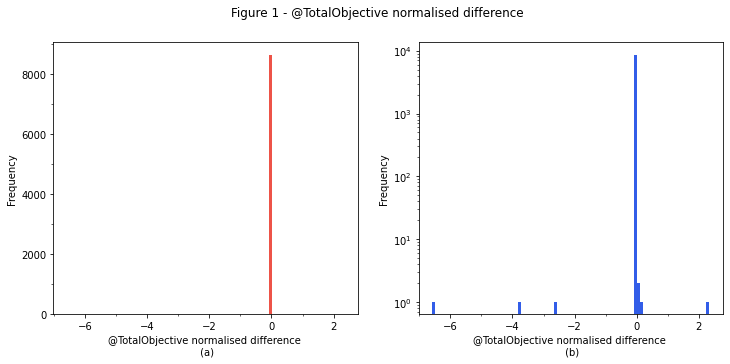

In [4]:
def plot_total_objective_histograms(run_id):
    """Plot total objective normalised difference histograms"""

    df = get_total_objective_normalised_difference(run_id=run_id)

    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1 = df.plot.hist(ax=ax1, bins=100, color='#eb4034', alpha=0.9)
    ax2 = df.plot.hist(ax=ax2, bins=100, color='#1c4be6', alpha=0.9)
    ax2.set_yscale('log')

    # Format labels
    ax1.set_xlabel('@TotalObjective normalised difference \n (a)')
    ax2.set_xlabel('@TotalObjective normalised difference \n (b)')

    # Format ticks
    ax1.yaxis.set_major_locator(MultipleLocator(2000))
    ax1.yaxis.set_minor_locator(MultipleLocator(1000))

    ax1.xaxis.set_major_locator(MultipleLocator(2))
    ax1.xaxis.set_minor_locator(MultipleLocator(1))

    ax2.xaxis.set_major_locator(MultipleLocator(2))
    ax2.xaxis.set_minor_locator(MultipleLocator(1))

    fig.suptitle('Figure 1 - @TotalObjective normalised difference')
    fig.set_size_inches(12, 5)
    

plot_total_objective_histograms(run_id=run_id)

Figure 1a indicates excellent correspondence between the Dispatch API's solution and the NEMDE solution. Outliers are identified for approximately seven dispatch intervals (0.081% of the sample), which are resolved in Figure 1b.

### Regions
The difference between region solutions obtained from the Dispatch API and NEMDE are shown in the following table:

In [5]:
display_summary_statistics_markdown(
    run_id=run_id, filename='regions.csv', element_id='region_id')

|       |   @ClearedDemand |   @DispatchedGeneration |   @DispatchedLoad |    @EnergyPrice |    @FixedDemand |     @L5Dispatch |   @L5RegDispatch |   @L60Dispatch |     @L6Dispatch |      @NetExport |    @R5Dispatch |   @R5RegDispatch |    @R60Dispatch |    @R6Dispatch |   @SurplusGeneration |
|:------|-----------------:|------------------------:|------------------:|----------------:|----------------:|----------------:|-----------------:|---------------:|----------------:|----------------:|---------------:|-----------------:|----------------:|---------------:|---------------------:|
| count |  43200           |          43200          |   43200           |  43200          | 43200           | 43200           |  43200           | 43200          | 43200           | 43200           | 43200          |  43200           | 43200           | 43200          |                43200 |
| mean  |     -0.00104562  |             -0.00106376 |      -0.000813725 |     28.6958     |    -1.40473e-06 |     0.000650245 |     -0.000693923 |    -0.00038178 |    -0.0466299   |    -0.000215906 |    -0.390474   |     -6.63012e-05 |    -0.000222241 |    -0.00119391 |                    0 |
| std   |      0.185128    |              0.485221   |       0.145322    |   3232.45       |     0.00288172  |     0.463755    |      0.793445    |     0.367114   |     3.23334     |     0.501924    |     5.74301    |      0.375522    |     5.02648     |     1.37914    |                    0 |
| min   |    -26.6615      |            -42.1148     |     -28           |   -449.565      |    -0.00499974  |   -28.0018      |    -20           |   -18.823      |   -55.4723      |   -42.107       |  -102.559      |    -15.7004      |   -75.3844      |   -32.7827     |                    0 |
| 0.1%  |     -0.0565752   |             -0.00819657 |      -0.00406594  |     -0.0044204  |    -0.00498888  |    -5           |    -10           |    -4.12015    |   -25           |    -0.0137336   |   -59          |     -3.68602     |   -46.0901      |   -13.9506     |                    0 |
| 1%    |     -0.00491602  |             -0.0049712  |      -2e-06       |     -0.00095801 |    -0.00489918  |    -0.00482201  |     -0.00499952  |    -0.004797   |   -14.9977      |    -0.00491321  |   -24          |     -0.005       |   -19.5606      |    -3.99976    |                    0 |
| 10%   |     -0.00399913  |             -0.004      |       0           |     -5e-05      |    -0.00399597  |    -0.0018103   |     -2e-06       |    -0.002078   |    -0.003333    |    -0.00394509  |    -0.00497246 |     -0.0023333   |    -0.00442946  |    -0.00358525 |                    0 |
| 25%   |     -0.00244773  |             -0.00252178 |       0           |     -2e-06      |    -0.00249715  |     0           |      0           |     0          |     0           |    -0.00233497  |    -0.000172   |      0           |    -0.000643147 |    -0.00013415 |                    0 |
| 50%   |      2.93107e-05 |              1.725e-05  |       0           |      0          |    -1.90567e-05 |     0           |      0           |     0          |     0           |     0           |     0          |      0           |     0           |     0          |                    0 |
| 75%   |      0.00252805  |              0.00253    |       0           |      3e-06      |     0.00247741  |     0           |      0           |     0          |     0.000475325 |     0.00243253  |     0          |      0           |     0           |     0          |                    0 |
| 90%   |      0.00406472  |              0.004015   |       0           |      0.000181   |     0.00400988  |     0.00191068  |      2e-06       |     0.00207637 |     0.003333    |     0.00401836  |     0.00412814 |      0.00180679  |     0.003544    |     0.0033011  |                    0 |
| 99%   |      0.00495861  |              0.00498101 |       0.000765991 |      0.00174    |     0.0048998   |     0.0048305   |      0.0049928   |     0.0048049  |    13           |     0.00495717  |    13          |      0.0048983   |    19.56        |     4          |                    0 |
| 99.9% |      0.034818    |              0.0370505  |       0.00377879  |      0.00953348 |     0.0049877   |     5           |     10           |     3.974      |    21.5878      |     0.0368679   |    42          |      3.63741     |    46.0934      |    13.5238     |                    0 |
| max   |     11.0937      |             35.3238     |       2.85348     | 572603          |     0.00499912  |    28           |     20           |    21.72       |    53.0024      |    35.3321      |    61          |     30.0033      |    65.3625      |    44.8793     |                    0 |

The `@EnergyPrice` metric is of particular interest. The mean difference for this metric is relatively high, yet excellent corresponce is reported over the 0.1-99.9th percentiles, suggesting outliers are responsible for this discrepancy. These outliers likely correspond to dispatch intervals when constraint violation penalty factors set prices. Note the Dispatch API does not ajdust prices to the price floor or ceiling if these thresholds are exceeded.

### Interconnectors

Summary statistics for the difference between interconnector solutions obtained from the Dispatch API and NEMDE outputs are shown in the following table:

In [6]:
display_summary_statistics_markdown(
    run_id=run_id, filename='interconnectors.csv', element_id='interconnector_id')

|       |   @Deficit |          @Flow |         @Losses |
|:------|-----------:|---------------:|----------------:|
| count |      51840 | 51840          | 51840           |
| mean  |          0 |     0.00318055 |    -0.000197088 |
| std   |          0 |     1.53926    |     0.175861    |
| min   |          0 |  -148.801      |   -21.5008      |
| 0.1%  |          0 |    -0.0308726  |    -0.00162513  |
| 1%    |          0 |    -5e-06      |    -5e-06       |
| 10%   |          0 |     0          |    -4e-06       |
| 25%   |          0 |     0          |    -2.68e-06    |
| 50%   |          0 |     0          |     0           |
| 75%   |          0 |     0          |     2.5e-06     |
| 90%   |          0 |     0          |     3.95e-06    |
| 99%   |          0 |     5.627e-06  |     5e-06       |
| 99.9% |          0 |     0.0193116  |     0.0320136   |
| max   |          0 |   160          |    16.2771      |

### Traders

Summary statistics for the difference between trader solutions obtained from the Dispatch API and outputs reported by the NEMDE are shown below:

In [7]:
display_summary_statistics_markdown(
    run_id=run_id, filename='traders.csv', element_id='trader_id')

|       |   @EnergyTarget |   @FSTargetMode |   @L5RegTarget |   @L5RegViolation |     @L5Target |   @L5Violation |    @L60Target |   @L60Violation |     @L6Target |   @L6Violation |   @R5RegTarget |   @R5RegViolation |     @R5Target |   @R5Violation |    @R60Target |   @R60Violation |     @R6Target |   @R6Violation |   @RampDnRate |   @RampUpRate |
|:------|----------------:|----------------:|---------------:|------------------:|--------------:|---------------:|--------------:|----------------:|--------------:|---------------:|---------------:|------------------:|--------------:|---------------:|--------------:|----------------:|--------------:|---------------:|--------------:|--------------:|
| count |     2.91048e+06 | 639360          |    2.91048e+06 |       2.91048e+06 |   2.91048e+06 |    2.91048e+06 |   2.91048e+06 |     2.91048e+06 |   2.91048e+06 |    2.91048e+06 |    2.91048e+06 |       2.91048e+06 |   2.91048e+06 |    2.91048e+06 |   2.91048e+06 |     2.91048e+06 |   2.91048e+06 |    2.91048e+06 |   2.78328e+06 |   2.78328e+06 |
| mean  |    -2.78505e-05 |      0.00141235 |   -1.00648e-05 |      -3.43587e-06 |   9.7026e-06  |   -1.37435e-06 |  -5.73738e-06 |    -1.37435e-06 |  -0.00069639  |   -2.74869e-06 |   -3.61178e-08 |      -1.37435e-06 |  -0.00579463  |   -1.37435e-06 |  -1.13507e-06 |    -1.37435e-06 |  -1.64888e-05 |   -1.37435e-06 |  -0.000125728 |  -0.000138799 |
| std   |     0.187107    |      0.172947   |    0.258997    |       0.00586163  |   0.532339    |    0.00117232  |   0.735048    |     0.00117232  |   0.530282    |    0.0026214   |    0.300822    |       0.00117232  |   1.63017     |    0.00117232  |   0.969267    |     0.00117232  |   0.637123    |    0.00117232  |   0.000727952 |   0.000808648 |
| min   |   -99.9589      |     -3          |  -50.0001      |     -10           | -77.5019      |   -1           | -91.7043      |    -1           | -44.8113      |   -4           |  -49.5063      |      -1           | -96.2397      |   -1           | -99.3684      |    -1           | -41.3333      |   -1           |  -0.005       |  -0.005       |
| 0.1%  |    -5e-06       |     -2          |   -3           |       0           |  -3.8649      |    0           |  -5           |     0           |  -5           |    0           |   -2           |       0           | -19.2345      |    0           | -10           |     0           |  -7.81775     |    0           |  -0.005       |  -0.005       |
| 1%    |    -2e-06       |      0          |    0           |       0           |   0           |    0           |   0           |     0           |   0           |    0           |    0           |       0           |   0           |    0           |   0           |     0           |   0           |    0           |  -0.00374714  |  -0.00376144  |
| 10%   |     0           |      0          |    0           |       0           |   0           |    0           |   0           |     0           |   0           |    0           |    0           |       0           |   0           |    0           |   0           |     0           |   0           |    0           |   0           |   0           |
| 25%   |     0           |      0          |    0           |       0           |   0           |    0           |   0           |     0           |   0           |    0           |    0           |       0           |   0           |    0           |   0           |     0           |   0           |    0           |   0           |   0           |
| 50%   |     0           |      0          |    0           |       0           |   0           |    0           |   0           |     0           |   0           |    0           |    0           |       0           |   0           |    0           |   0           |     0           |   0           |    0           |   0           |   0           |
| 75%   |     0           |      0          |    0           |       0           |   0           |    0           |   0           |     0           |   0           |    0           |    0           |       0           |   0           |    0           |   0           |     0           |   0           |    0           |   0           |   0           |
| 90%   |     0           |      0          |    0           |       0           |   0           |    0           |   0           |     0           |   0           |    0           |    0           |       0           |   0           |    0           |   0           |     0           |   0           |    0           |   0           |   0           |
| 99%   |     2e-06       |      0          |    0           |       0           |   0           |    0           |   0           |     0           |   0           |    0           |    0           |       0           |   0           |    0           |   0           |     0           |   0           |    0           |   1.43051e-06 |   2.86102e-06 |
| 99.9% |     5e-06       |      4          |    3           |       0           |   3.91676     |    0           |   5           |     0           |   5           |    0           |    2           |       0           |  15.5191      |    0           |   8.98624     |     0           |   6.70383     |    0           |   0.00472534  |   0.00499995  |
| max   |    79.983       |      4          |   43.6         |       0           |  87.3195      |    0           | 116.54        |     0           |  45.5015      |    0           |   50.0001      |       0           | 102.2         |    0           | 117           |     0           |  53.4618      |    0           |   0.00499995  |   0.00499995  |

Energy market dispatch targets obtained from the Dispatch API correpsond closely to those within NEMDE outputs, illustrated by the following histograms:

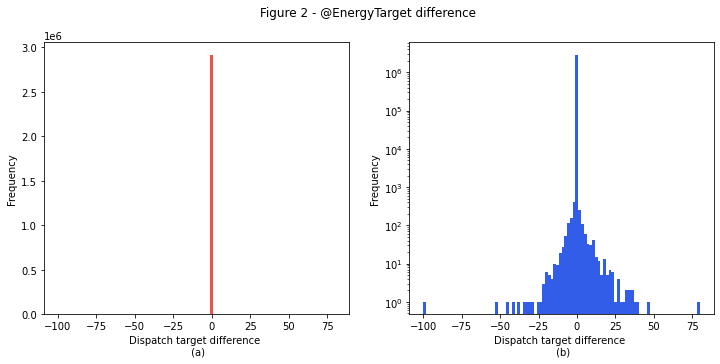

In [8]:
def plot_trader_solution_difference(run_id, key):
    """Plot trader solution difference for a given key"""

    traders = load_backtest_results(run_id=run_id, filename='traders.csv')
    data = traders.loc[traders['key'] == key, :].set_index(['trader_id', 'case_id'])
    difference = data['model'].subtract(data['actual'])
    
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1 = difference.plot.hist(ax=ax1, bins=100, color='#eb4034', alpha=0.9)
    ax2 = difference.plot.hist(ax=ax2, bins=100, color='#1c4be6', alpha=0.9)
    
    ax2.set_yscale('log')

    ax1.set_xlabel('Dispatch target difference \n (a)')
    ax2.set_xlabel('Dispatch target difference \n (b)')

    
    fig.suptitle('Figure 2 - @EnergyTarget difference')
    fig.set_size_inches(12, 5)
    
    return difference

    
difference = plot_trader_solution_difference(run_id=run_id, key='@EnergyTarget')

Figure 2a demonstrates excellent correpsondence between @EnergyTarget solutions obtained from the Dispatch API and NEMDE outputs. Material differences are only observed for a small proportion of observations, which are shown in Figure 2b where a log scale has been used for the y-axis.

## Reasons for differences
Differences between solutions obtained from the Dispatch API and the NEMDE may be due to several factors. As the Dispatch API is an approximation of the NEMDE, it is possible omitted features may give rise to these differences. However, there are also other factors, unrelated to model accuracy, that may explain some of these discrepancies. For instance, **there is no guarantee the dispatch solution produced by the NEMDE is unique - it is possible an alternative combination of dispatch targets could meet demand and satisfy network constraints at the same cost**. Such situations may arise when the marginal unit of demand can be satisfied by multiple generators, each having the same offer price. The following stylised example illustrates the concept.

Consider a simple system with only two generators that have the following marginal costs and offer quantities.

| Generator | Marginal Cost ($/MWh) | Offer (MW) |
| :------  | --------------------- | ---------- |
| A | 20 | 100 |
| B | 30 | 80 |

Assume system demand is 120 MW and there are no network constraints. The market operator seeks to dispatch these generators such that demand is met at the lowest cost. In this scenario Generator A would be dispatched first (as it is the cheaper unit), followed by Generator B for the portion of demand that cannot be met by Generator A. This would lead to the following dispatch targets:

| Generator | Target (MW) |
| :------  | --- |
| A | 100 |
| B | 20 |

The solution here is unique - the market operator will always seek to use the cheaper unit (Generator A) to the greatest extent possible before moving on to more expensive units.

But what happens if two units have the same marginal cost? For example:

| Generator | Marginal Cost ($/MWh) | Offer (MW) |
| :------  | --------------------- | ---------- |
| A | 20 | 100 |
| B | 20 | 80 |

How should the market operator decide upon dispatch targets for each generator? So long as total generation meets demand, the market operator is indifferent as to how generation targets are allocated to each unit - the total cost will always be the same, and the dispatch solution is no longer unique.

The NEMDE addresses the issue of price-tied generators by using a tie-breaking model which seeks to dispatch price-tied generators in proportion to their offer quantities. In the example above, this feature of the NEMDE would motivate the following dispatch outcomes:

| Generator | Target (MW) |
| :------  | --- |
| A | (100 / 180) * 120 = 66.67 |
| B | (80 / 180) * 120 = 53.33 |

While a tie-breaking model is used in the energy market, **the NEMDE does not apply a tie-breaking model to offers made in FCAS markets**. Consequently, there is no guarantee the NEMDE will return a unique FCAS solution. This means identical formulations of the NEMDE run on different computers may return different results. Factors such as solver settings, floating point precision, and even computer hardware may result in different dispatch targets. This can make it difficult to interpret the differences observed when reviewing backtest results as discrepancies could be due to innaccuraricies in the approximated model, or a result of innate mathematical properties associated with the NEMDE's formulation. 

## Summary
Backtest results demonstrate close correspondence between solutions obtained from the Dispatch API and NEMDE outputs. Consilience can be observed in the evidence presented as multiple solution attributes are in excellent agreement. However, there are a handful of dispatch intervals for which outliers exist. These may due to deficiencies in the model used by the Dispatch API, or a consequence of innate properties relating to the NEMDE's mathematical formulation. Additional diagnostic analysis is underway to identify the cause of these discrepancies, which will inform efforts to further improve the Dispatch API's performance.